# NOAA 自然重建数据的处理

这个笔记本展示如何处理 NOAA 自然重建数据，如何进行贝叶斯组合，如何进行空间代表性分析，并制作论文的第一小节数据插图。

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import os
from hydra import compose, initialize
from mksci_font import config_font

with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config.yaml")
os.chdir(cfg.ds.root)

config_font({"font.size": 9})

预期的结果包括：

We aggregated nine reconstructed datasets (==see Methods for more details==) of summer (July-August-September) precipitation or Yellow River runoff based on natural proxies into a natural WDI series. During the validation period, when abundant instrumental measurements were available (1901-2010 CE), the Pearson correlation coefficient between the aggregated natural WDI series and the validation data is ==0.40== (p < 0.01). Under a 30-year low-pass filtering, the series well reflects the variation trend of the WDI based on instrumental observations during the validation period (**Figure 2a**) and is generally consistent with the WDI series estimated based on historical archives across the pre-instrumental period (**Figure 2b**). Spatially, over 90% of the historical archives' sites we used were located in areas that showed a significant positive correlation (==20== sites $p < 0.05$ and ==7== sites $p < 0.1$) with the natural WDI series (**Figure 2c**). The good spatial-temporal correlations both indicate the reliability of our data aggregation. Changing the estimation method of WDI based on historical archives and dataset selection of natural proxies does not affect the overall results (see **Supplementary Information S1 and S2** for more details), demonstrating its robustness. We also verified that the distributions of the two reconstructed WDI datasets during the pre-instrumental period are similar (**Figure 2d**). Therefore, we assume that the reconstruction of natural WDI series can, to some extent, reflect the "objective" climatic anomaly and can be compared with the estimated WDI dataset based on historical archives. 

In [3]:
# 需要写到论文里的预期结果
expected_results = {
    "n_datasets": None,
    "corr_with_validation": None,
    "n_pass_years": None,
    "sig_sites_percentage": None,
    "sig_sites_ratio": None,
    "n_sites_sig005": None,
    "n_sites_sig01": None,
}

## 筛选与合并数据

### 读取数据

我们一共整理了 13 套在 NOAA 上可以自由下载的[使用树轮重建的古气候数据](https://docs.google.com/spreadsheets/d/1HAICoWO_Uh40iDllIUKE3nYOCVLGNgfWML-6ecTKegU/edit?usp=sharing)。

In [4]:
from shifting_baseline.data import load_nat_data
from shifting_baseline.constants import START

datasets, uncertainties = load_nat_data(
    folder=cfg.ds.noaa,
    includes=cfg.ds.includes,
    start_year=START,
    standardize=True,
)
datasets.tail()

Directory /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 checked.
Found 19 files in /Users/songshgeo/Documents/Datasets/东亚古气候重建数据.
Found 9 files matching the pattern.


,yi2010,yang2016,tan2011,xu2023c,liu2020,yi2012,li2015b,chen2020f,li2019a
year,,,,,,,,,
2009,NaN,-0.568723,NaN,-1.466621,-0.314233,NaN,NaN,-0.346202,2.343614
2010,NaN,0.307108,NaN,1.170888,-0.302521,NaN,NaN,-0.580140,2.828464
2011,NaN,NaN,NaN,1.248765,-0.760710,NaN,NaN,-0.752154,NaN
2012,NaN,NaN,NaN,-1.204711,0.169405,NaN,NaN,-2.389725,NaN
2013,NaN,NaN,NaN,0.140132,0.748762,NaN,NaN,NaN,NaN


其中 ，不是所有的数据都会被使用，下面是使用的数据及其时空范围：

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt

# 设置绘图风格
sns.set_theme(style="white")

# 检查数据
for name, ds in datasets.items():
    if name not in cfg.ds.includes:
        print(f"{name} 在使用列表中，但没有读取成功，请检查")
        continue
    index = ds.dropna().index
    print(f"{name} 的时间范围是：{index.min()} - {index.max()}")

# 存储数据集量
expected_results["n_datasets"] = len(datasets.columns)

yi2010 的时间范围是：1600 - 2000
yang2016 的时间范围是：1470 - 2010
tan2011 的时间范围是：1005 - 1975
xu2023c 的时间范围是：1588 - 2013
liu2020 的时间范围是：1493 - 2013
yi2012 的时间范围是：1470 - 2002
li2015b 的时间范围是：1872 - 2003
chen2020f 的时间范围是：1570 - 2012
li2019a 的时间范围是：1000 - 2010


### 合并数据

现在使用贝叶斯组合方法合并数据：

In [6]:
from shifting_baseline.mc import combine_reconstructions

combined, trace = combine_reconstructions(
    datasets,
    uncertainties,
    standardize=True,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


合成的数据进行导出，在其它笔记本中进行进一步分析

In [7]:
# 导出合成数据
combined.to_csv(cfg.ds.out.tree_ring)
uncertainties.to_csv(cfg.ds.out.tree_ring_uncertainty)
combined.head()
print("合成数据导出成功, 路径为:", cfg.ds.out.tree_ring)

,mean,sd,hdi_3%,hdi_97%
year,,,,
1000,0.296,0.519,-0.658,1.283
1001,-0.022,0.540,-0.956,1.078
1002,0.781,0.624,-0.434,1.937
1003,0.428,0.673,-0.889,1.641
1004,-0.221,0.654,-1.491,0.952


合成数据导出成功, 路径为: /Users/songshgeo/Documents/VSCode/shifting_baseline/data/combined_mean.csv


## 空间代表性

计算降水量的 z-score, 得到的数据应该包括 1900-2017 年的降水：

[原始数据](https://essd.copernicus.org/articles/11/1931/2019/)来源为 ESSD 的一篇文章，这里只用了夏季（July, August, Sepetember, JAS）三个月的数据，进行聚合之后再升尺度。

In [8]:
from shifting_baseline.data import load_validation_data

# 读取数据
summer_precip = load_validation_data(
    data_path=cfg.ds.instrumental.output,
    resolution=cfg.resolution,
)
print("Resolution:", summer_precip.rio.resolution())

# 计算降水量的 z-score
summer_precip_z = (summer_precip - summer_precip.mean(dim="year")) / summer_precip.std(
    dim="year"
)

# 查看数据形状
summer_precip.shape

Resolution: (0.5, -0.5)


(117, 79, 128)

首先计算看看每个数据的空间代表性。

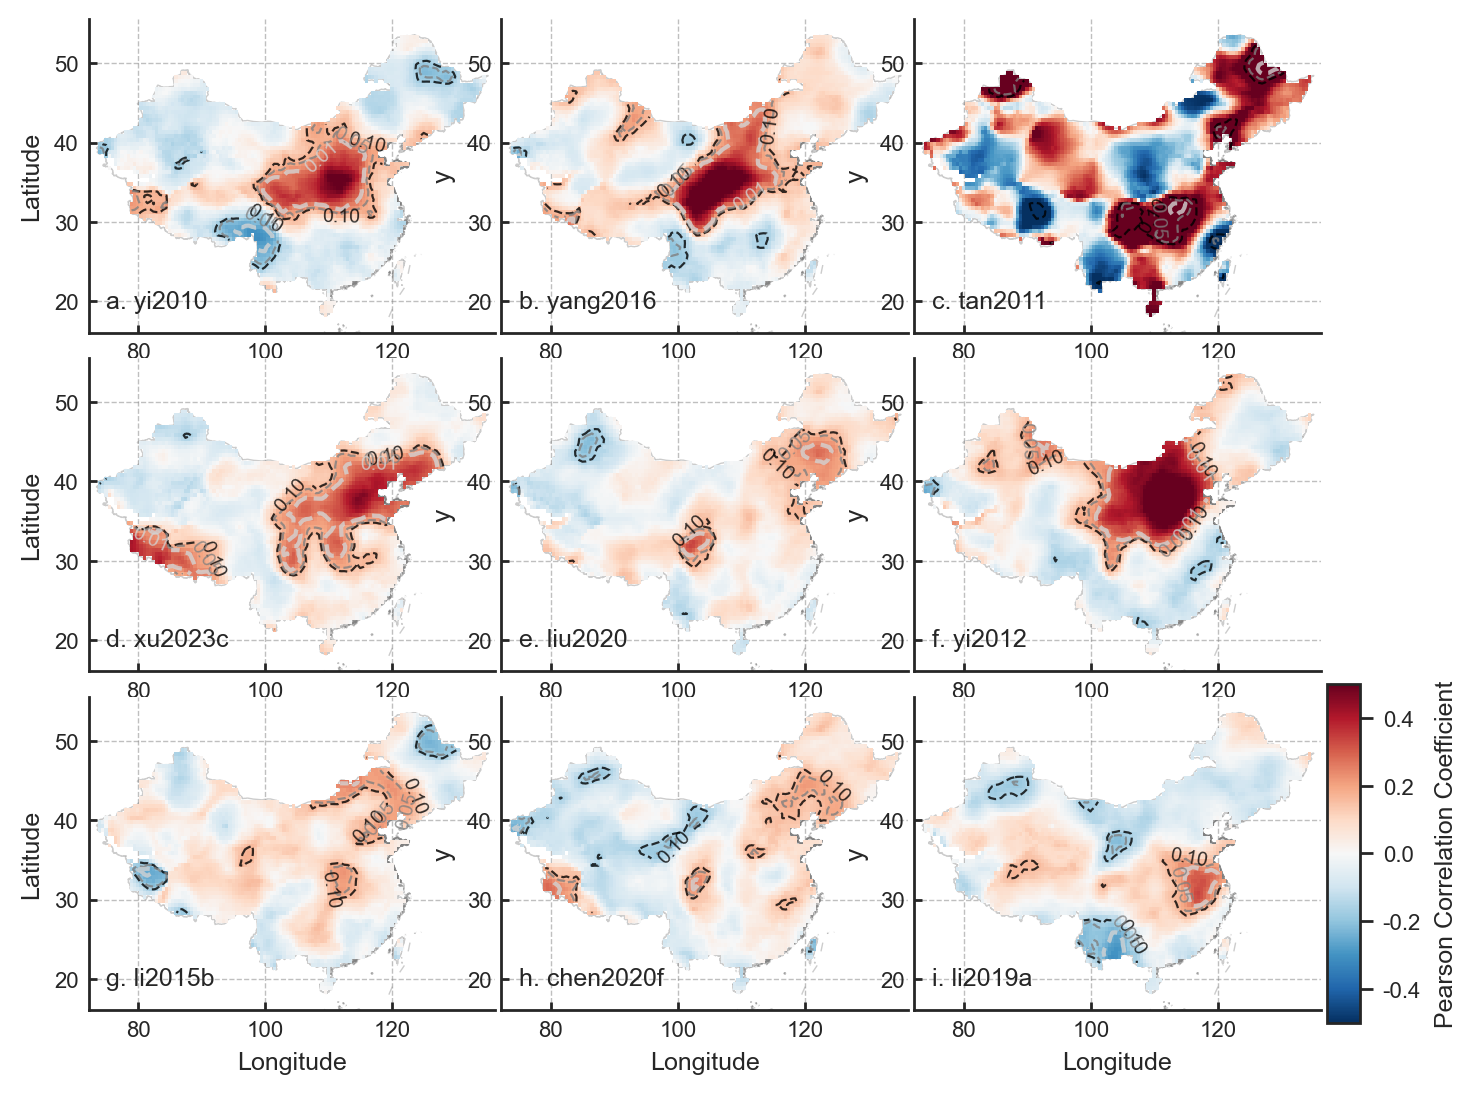

In [9]:
# 更简洁的seaborn风格版本
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import matplotlib.colors as colors

from shifting_baseline.utils.plot import plot_corr_map
from shifting_baseline.utils.calc import calc_corr
import xarray as xr

# 设置seaborn风格
sns.set_style("ticks")
sns.set_context("paper")


def plot_correlation_maps_seaborn(datasets, summer_precip_z, summer_precip, cfg):
    """使用seaborn风格绘制相关性地图"""

    n_datasets = len(datasets.columns)
    ncols = 3
    nrows = (n_datasets + ncols - 1) // ncols

    # 创建图形和网格 - 为colorbar预留空间
    fig = plt.figure(figsize=(8.2, 2.2 * nrows))
    gs = GridSpec(
        nrows,
        ncols + 1,
        figure=fig,
        hspace=0,
        wspace=0.02,
        width_ratios=[1, 1, 1, 0.08],
    )  # 最后一列给colorbar

    for idx, col in enumerate(datasets.columns):
        row = idx // ncols
        col_idx = idx % ncols

        # 创建子图
        ax = fig.add_subplot(gs[row, col_idx])

        # 计算相关性
        series = datasets[col].to_xarray()
        common_years = np.intersect1d(series.year.values, summer_precip_z.year.values)

        corr = xr.apply_ufunc(
            calc_corr,
            summer_precip_z.sel(year=common_years),
            series.sel(year=common_years),
            input_core_dims=[["year"], ["year"]],
            output_core_dims=[[], [], []],
            vectorize=True,
            output_dtypes=[float, float, int],
        )

        # 绘制地图 - 禁用单个colorbar
        plot_corr_map(
            corr[0],
            corr[1],
            threshold=0.1,
            ax=ax,
            base_maps=cfg.ds.base_maps,
            mask=False,
            crs=summer_precip.rio.crs,
            add_colorbar=False,
        )

        # 设置数据集名称
        label = chr(ord("`") + 1 + idx) + ". " + col
        ax.text(75, 20, label, ha="left", va="center", fontsize=9)

        # seaborn风格的坐标轴设置
        ax.tick_params(labelsize=8, direction="in", length=3)

        # 只在边缘显示标签
        if row == nrows - 1:  # 最后一行
            ax.set_xlabel("Longitude", fontsize=9)
        if col_idx == 0:  # 第一列
            ax.set_ylabel("Latitude", fontsize=9)

    # 添加共享colorbar - 使用简单的mappable方法
    cbar_ax = fig.add_subplot(gs[-1, -1])

    # 创建简单的mappable对象
    norm = colors.Normalize(vmin=-0.5, vmax=0.5)
    sm = cm.ScalarMappable(cmap="RdBu_r", norm=norm)
    sm.set_array([])

    # 创建colorbar
    cbar = plt.colorbar(
        sm,
        cax=cbar_ax,
        shrink=0.6,
        aspect=20,
        pad=0.1,
    )
    cbar.set_label(
        "Pearson Correlation Coefficient",
        fontsize=9,
        labelpad=5,
    )
    cbar.ax.tick_params(labelsize=8)

    return fig


# 使用seaborn风格
fig = plot_correlation_maps_seaborn(datasets, summer_precip_z, summer_precip, cfg)
plt.show();

### 合成后的数据

,name_ch,name_en,region,lon,lat,NAME,省,市,geometry
15,兰州,Lanzhou,华北地区,103.726610,35.181546,临洮县,甘肃省,定西市,POINT (103.72661 35.18155)
16,天水,Tianshui,华北地区,105.600436,34.110788,秦州区,甘肃省,天水市,POINT (105.60044 34.11079)
18,银川,Yinchuan,华北地区,106.135814,37.412291,红寺堡区,宁夏回族自治区,吴忠市,POINT (106.13581 37.41229)
21,榆林,Yulin,华北地区,109.734749,38.066642,横山区,陕西省,榆林市,POINT (109.73475 38.06664)
22,延安,Yan'an,华北地区,109.556290,36.371276,宝塔区,陕西省,延安市,POINT (109.55629 36.37128)


(1000.0, 2010.0)

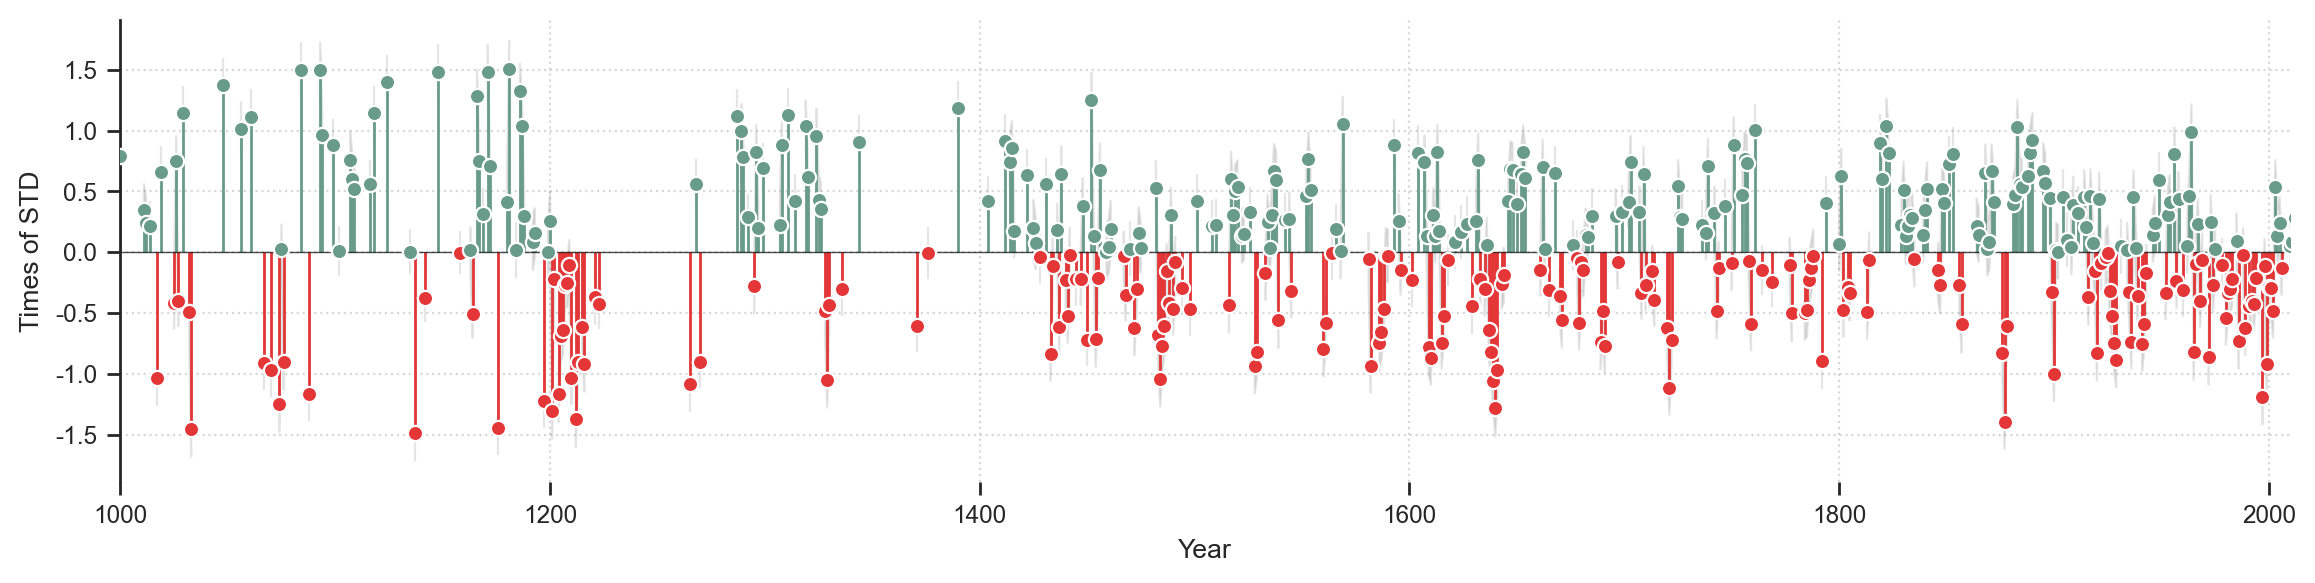

In [46]:
from shifting_baseline.data import HistoricalRecords
from shifting_baseline.utils.plot import plot_std_times
from shifting_baseline.constants import START, FINAL

hist = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
    to_std="sampling",
)
region_gdf = hist.shp.copy()
region_gdf.head()

pred = hist.aggregate(to_int=False)
std = hist._std.mean(axis=1).ffill()
ax = plot_std_times(data=pred)
ax.fill_between(std.index, pred + std, pred - std, color="gray", alpha=0.2)
ax.set_xlim(START, FINAL)

空间相关性

/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_83413/2723312308.py:29: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax1.legend(loc="upper left")


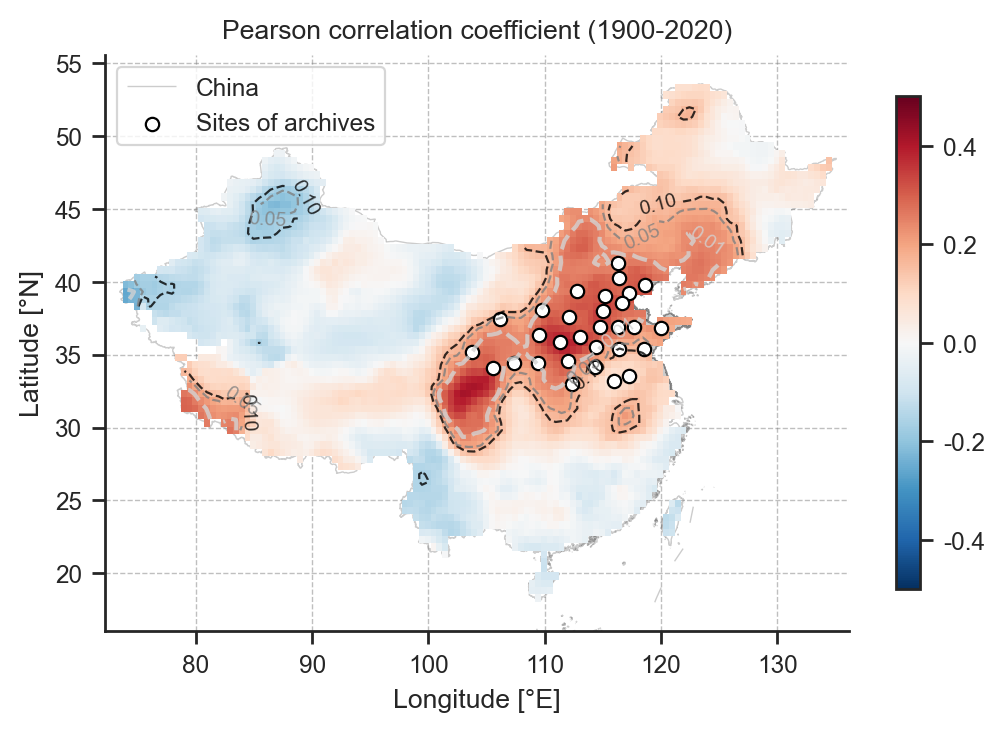

In [47]:
import geopandas as gpd

outline = gpd.read_file(cfg.how.shp)

series = combined["mean"].to_xarray()
common_years = np.intersect1d(series.year.values, summer_precip_z.year.values)
series = combined["mean"].to_xarray()
corr = xr.apply_ufunc(
    calc_corr,
    summer_precip_z.sel(year=common_years),
    series.sel(year=common_years),
    input_core_dims=[["year"], ["year"]],
    output_core_dims=[[], [], []],
    vectorize=True,
    output_dtypes=[float, float, int],
)
ax1 = plot_corr_map(
    corr[0],
    corr[1],
    threshold=0.1,
    mask=False,
    base_maps=cfg.ds.base_maps,
    crs=summer_precip.rio.crs,
)
region_gdf.plot(ax=ax1, color="white", edgecolor="black", label="Sites of archives")
ax1.set_title("Pearson correlation coefficient (1900-2020)")
ax1.set_xlabel("Longitude [°E]")
ax1.set_ylabel("Latitude [°N]")
ax1.legend(loc="upper left")
plt.show();

## 分布测定

最佳分布：Student-t（t）表现最佳：

- 最低sumsquare_error（1.003480），表明直方图拟合最好。
- 较低的AIC（495.670695）和BIC（507.652580），优于lognorm和gamma。
- 最低ks_statistic（0.040494）和最高ks_pvalue（0.5134515），CDF拟合极佳。

次佳分布：lognorm：
- sumsquare_error（1.010543）、AIC（500.570491）、BIC（512.552375）略逊于t。
- ks_statistic（0.040599）和ks_pvalue（0.5101007）与t接近，拟合良好。

In [48]:
from shifting_baseline.data import check_distribution
from matplotlib import pyplot as plt


summary = check_distribution(combined["mean"], only_best=False)

summary
print(f"可以看出，对树轮数据的最佳分布拟合是：{summary.index[0]}")

2025-09-15 09:21:02.512 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=11.263827)
2025-09-15 09:21:02.512 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=7.568748)
2025-09-15 09:21:02.515 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=0.739878)
2025-09-15 09:21:02.516 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=4.062897)
2025-09-15 09:21:02.526 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=7.327852)
2025-09-15 09:21:02.527 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=2.251473)
2025-09-15 09:21:02.532 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=0.817257)
2025-09-15 09:21:02.533 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,0.739878,413.394822,423.238139,inf,0.027290,0.429345
t,0.741423,414.932618,429.697593,inf,0.027389,0.424744
lognorm,0.743541,416.476543,431.241518,inf,0.027991,0.397573
gamma,0.768622,413.574973,428.339947,inf,0.033857,0.191073
chi2,0.817257,416.423543,431.188518,inf,0.041354,0.060612


可以看出，对树轮数据的最佳分布拟合是：norm


合并后的数据符合正态分布

### 历史站点分布在哪里

注意这里，先计算每个格点 z-score 再平均，和先计算平均降水，再转化成 z-score 效果是不一样的。我们的目标是得到整个这校验期的指数，所以先平均降水再计算分数比较合理。

<Axes: xlabel='year'>

校验数据导出成功, 路径为: /Users/songshgeo/Documents/VSCode/shifting_baseline/data/summer_precip_z.csv


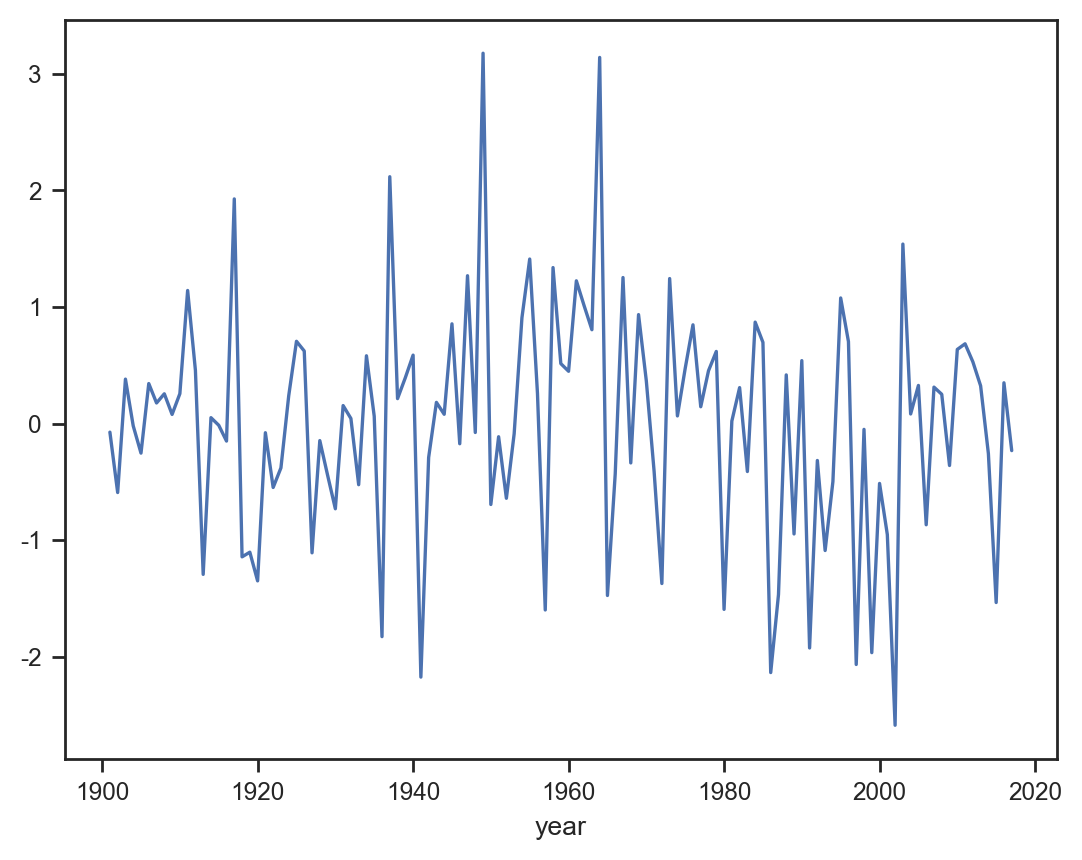

In [49]:
sel_dict = hist.get_bounds("x", "y")
prec_mean = summer_precip.sel(sel_dict).mean(dim=["x", "y"]).to_series()
prec_z = (prec_mean - prec_mean.mean()) / prec_mean.std()

prec_z.plot()
prec_z.to_csv(cfg.ds.out.precip_z)
print("校验数据导出成功, 路径为:", cfg.ds.out.precip_z)

把每个历史材料站点所在位置的【树轮 v.s. 校验】数据相关性进行记录。

In [50]:
lons = region_gdf.lon.values
lats = region_gdf.lat.values

hist_sites_corr = region_gdf[["name_ch", "name_en", "lon", "lat"]].copy()
rs, ps = [], []
for lon, lat in zip(hist_sites_corr.lon, hist_sites_corr.lat):
    r = corr[0].sel(x=lon, y=lat, method="nearest").item()
    p = corr[1].sel(x=lon, y=lat, method="nearest").item()
    rs.append(r)
    ps.append(p)

hist_sites_corr["r"] = rs
hist_sites_corr["p"] = ps
hist_sites_corr.to_csv(cfg.ds.out.sites_corr, index=False)
# 相关性
hist_sites_corr.head()

,name_ch,name_en,lon,lat,r,p
15,兰州,Lanzhou,103.726610,35.181546,0.246466,0.008499
16,天水,Tianshui,105.600436,34.110788,0.290596,0.001794
18,银川,Yinchuan,106.135814,37.412291,0.209909,0.025650
21,榆林,Yulin,109.734749,38.066642,0.251967,0.007097
22,延安,Yan'an,109.556290,36.371276,0.305307,0.001008


In [61]:
mask = hist_sites_corr["p"] < 0.1
n_sig = mask.sum()
print(
    f"{len(hist_sites_corr)} 个站点中，有 {n_sig} 个站点通过了 0.1 显著性水平检验 ({n_sig/len(hist_sites_corr):.2%})"
)

print("相关性描述性统计：")
hist_sites_corr[mask]["r"].describe()

30 个站点中，有 27 个站点通过了 0.1 显著性水平检验 (90.00%)
相关性描述性统计：


count    27.000000
mean      0.269823
std       0.055154
min       0.168864
25%       0.231316
50%       0.278996
75%       0.308915
max       0.400398
Name: r, dtype: float64

## 对比自然数据与校验数据

这里我们将展示自然数据的：

- 年值
- 30 年低通滤波
- 上下 1 倍 RMSE 的范围


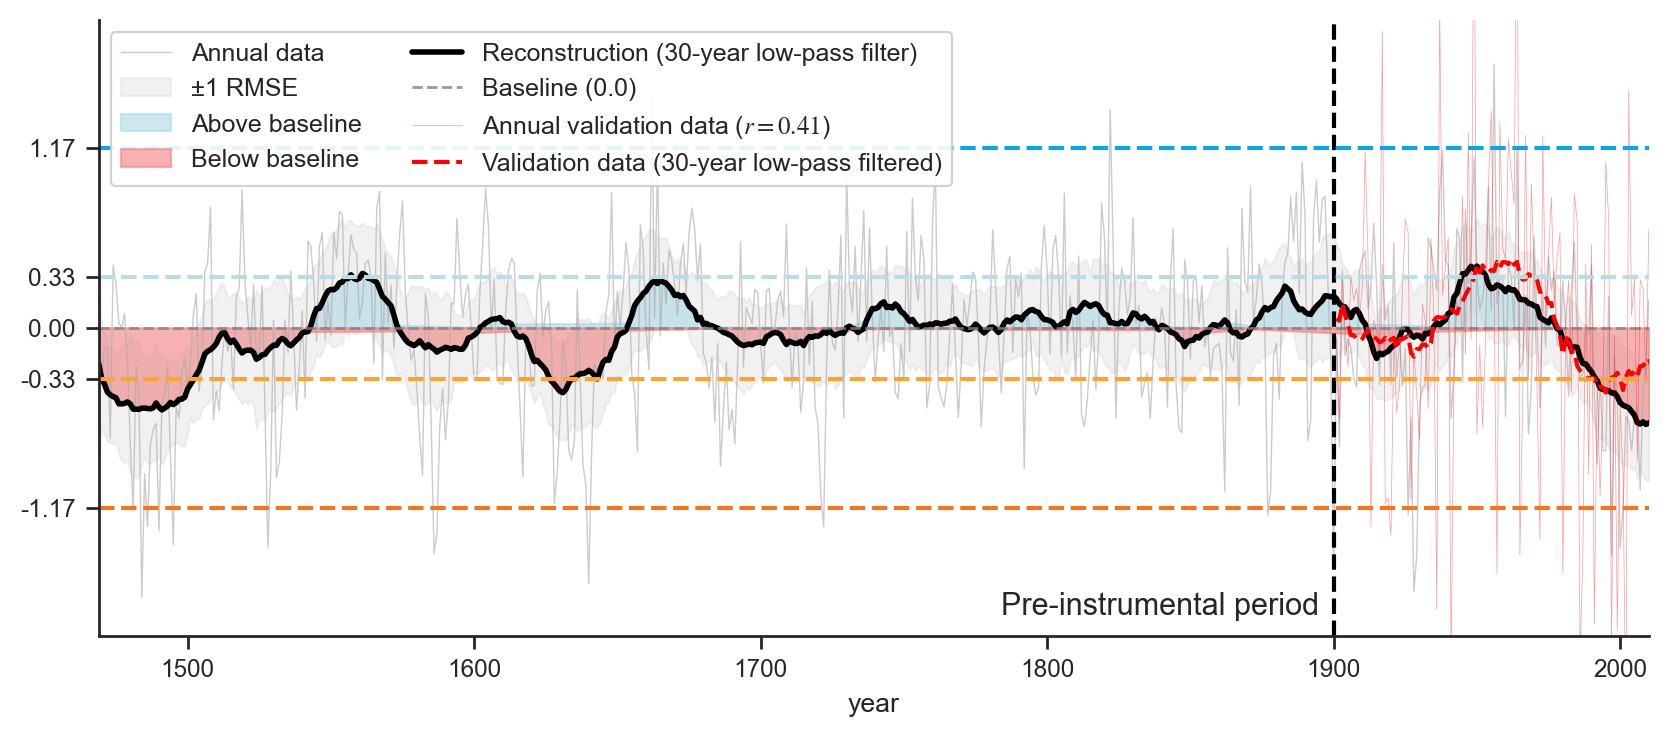

In [52]:
from shifting_baseline.utils.plot import plot_time_series_with_lowpass
from shifting_baseline.utils.calc import low_pass_filter
from shifting_baseline.constants import (
    STAGE1,
    END,
    FINAL,
    THRESHOLDS,
    COLORS,
    STD_THRESHOLDS,
)

tree_ring_z = combined["mean"].loc[STAGE1:FINAL]
tree_ring_std = combined["sd"].loc[STAGE1:FINAL]
# 低通滤波
low_pass_cfg = cfg.get("low_pass", {})
mean_pass = low_pass_filter(tree_ring_z, **low_pass_cfg)
prec_z_pass = low_pass_filter(prec_z, **low_pass_cfg)

validation_corr = prec_z.corr(tree_ring_z.loc[END:FINAL])

# 绘制时间序列
ax1 = plot_time_series_with_lowpass(
    data=tree_ring_z,
    filtered_data=mean_pass,
    baseline=0,
    rmse_data=tree_ring_std,
    unit="z-score",
    ylabel="Anormaly of JAS Precipitation",
)
prec_z.plot(
    ax=ax1,
    color="red",
    lw=0.25,
    alpha=0.4,
    label=f"Annual validation data ($r={validation_corr:.2f}$)",
)
prec_z_pass.plot(
    ax=ax1,
    color="red",
    lw=1.5,
    ls="--",
    label="Validation data (30-year low-pass filtered)",
)
ax1.axvline(END, color="black", lw=1.5, ls="--")
ax1.text(END - 5, -1.9, "Pre-instrumental period", ha="right", va="bottom", fontsize=11)

for th, color in zip(THRESHOLDS, COLORS):
    ax1.axhline(th, color=color, lw=1.5, ls="--")
# 设置图例
ax1.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=2)
ax1.set_xlim(STAGE1, FINAL)
ax1.set_yticks(STD_THRESHOLDS)
ax1.set_ylim(-2, 2)
ax1.set_title("")

plt.show();

绘制合并后的数据可以看出，在第一个阶段波动更明显；1700 之后的波动没有那么明显。

## 对比历史数据与树轮数据

tree_ring_subset 形状: (432,)
tree_ring_subset 类型: <class 'pandas.core.series.Series'>
agg_hist 形状: (1021,)
agg_hist 类型: <class 'pandas.core.series.Series'>
tree_ring_subset 索引范围: 1469 到 1900
agg_hist 索引范围: 1000 到 2020
共同索引长度: 432
对齐后 tree_ring 形状: (432,)
对齐后 agg_hist 形状: (432,)
tree_ring_aligned 缺失值数量: 0
agg_hist_aligned 缺失值数量: 224
清理后 tree_ring 形状: (208,)
清理后 agg_hist 形状: (208,)


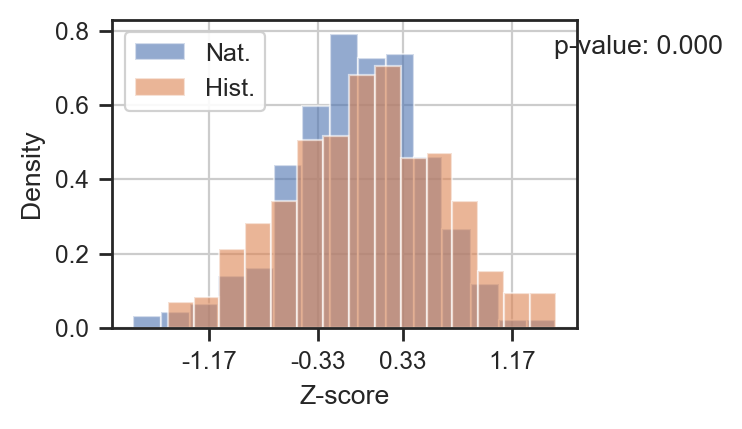

In [88]:
from scipy.stats import ttest_rel

fig, ax1 = plt.subplots(figsize=(3, 2))
tree_ring_subset = tree_ring_z.loc[STAGE1:END]
tree_ring_subset.hist(density=True, alpha=0.6, bins=15, ax=ax1, label="Nat.")

# 历史数据
agg_hist = hist.aggregate(cfg.agg_method, to_int=False)
agg_hist.hist(density=True, alpha=0.6, bins=15, ax=ax1, label="Hist.")

# 诊断：检查数据形状和类型
print("tree_ring_subset 形状:", tree_ring_subset.shape)
print("tree_ring_subset 类型:", type(tree_ring_subset))
print("agg_hist 形状:", agg_hist.shape)
print("agg_hist 类型:", type(agg_hist))

# 检查时间索引是否匹配
print(
    "tree_ring_subset 索引范围:",
    tree_ring_subset.index.min(),
    "到",
    tree_ring_subset.index.max(),
)
print("agg_hist 索引范围:", agg_hist.index.min(), "到", agg_hist.index.max())

# 确保两个序列有相同的时间范围
common_index = tree_ring_subset.index.intersection(agg_hist.index)
print("共同索引长度:", len(common_index))

if len(common_index) > 0:
    # 使用共同索引进行 t 检验
    tree_ring_aligned = tree_ring_subset.loc[common_index]
    agg_hist_aligned = agg_hist.loc[common_index]
    print("对齐后 tree_ring 形状:", tree_ring_aligned.shape)
    print("对齐后 agg_hist 形状:", agg_hist_aligned.shape)

    # 检查是否有缺失值
    print("tree_ring_aligned 缺失值数量:", tree_ring_aligned.isna().sum())
    print("agg_hist_aligned 缺失值数量:", agg_hist_aligned.isna().sum())

    # 移除缺失值
    valid_mask = ~(tree_ring_aligned.isna() | agg_hist_aligned.isna())
    tree_ring_clean = tree_ring_aligned[valid_mask]
    agg_hist_clean = agg_hist_aligned[valid_mask]

    print("清理后 tree_ring 形状:", tree_ring_clean.shape)
    print("清理后 agg_hist 形状:", agg_hist_clean.shape)

    if len(tree_ring_clean) > 0:
        ttest = ttest_rel(tree_ring_clean, agg_hist_clean)
        ax1.text(
            0.95,
            0.95,
            f"p-value: {ttest.pvalue:.3f}",
            ha="left",
            va="top",
            transform=ax1.transAxes,
        )
    else:
        print("警告：清理后没有有效数据，无法进行 t 检验")
        ax1.text(
            0.95,
            0.95,
            "No valid data for t-test",
            ha="left",
            va="top",
            transform=ax1.transAxes,
        )
else:
    print("警告：没有共同的时间索引，无法进行 t 检验")
    ax1.text(
        0.95, 0.95, "No common time index", ha="left", va="top", transform=ax1.transAxes
    )

ax1.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=1)
ax1.set_xticks(THRESHOLDS)
ax1.set_xlabel("Z-score")
ax1.set_ylabel("Density")
ax1.set_title("")
plt.show();

In [55]:
check_distribution(agg_hist, only_best=False)

2025-09-15 09:22:07.640 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=11.306225)
2025-09-15 09:22:07.648 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=20.963793)
2025-09-15 09:22:07.649 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=2.684978)
2025-09-15 09:22:07.651 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=4.144034)
2025-09-15 09:22:07.652 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=6.566733)
2025-09-15 09:22:07.652 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=6.859603)
2025-09-15 09:22:07.657 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=2.699952)
2025-09-15 09:22:07.671 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,2.684978,292.321102,300.429981,inf,0.022479,0.979230
t,2.684978,294.321094,306.484412,inf,0.022479,0.979229
lognorm,2.691992,294.847748,307.011066,inf,0.023592,0.967232
gamma,2.699952,294.381643,306.544961,inf,0.026199,0.924279
exponpow,2.811753,278.947314,291.110632,inf,0.036282,0.615788


## 最终作图

图 1 我希望包括以下内容：

- 证明对数论数据的拟合效果不错
- 证明历史数据和数论数据都能在基本的旱涝历史上达到一致
- 证明空间上有代表性
- 证明历史判断比树轮的判断更极端

/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:213: RuntimeWarning: Mean of empty slice
  np.mean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_83413/4091454888.py:105: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax3.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=1)


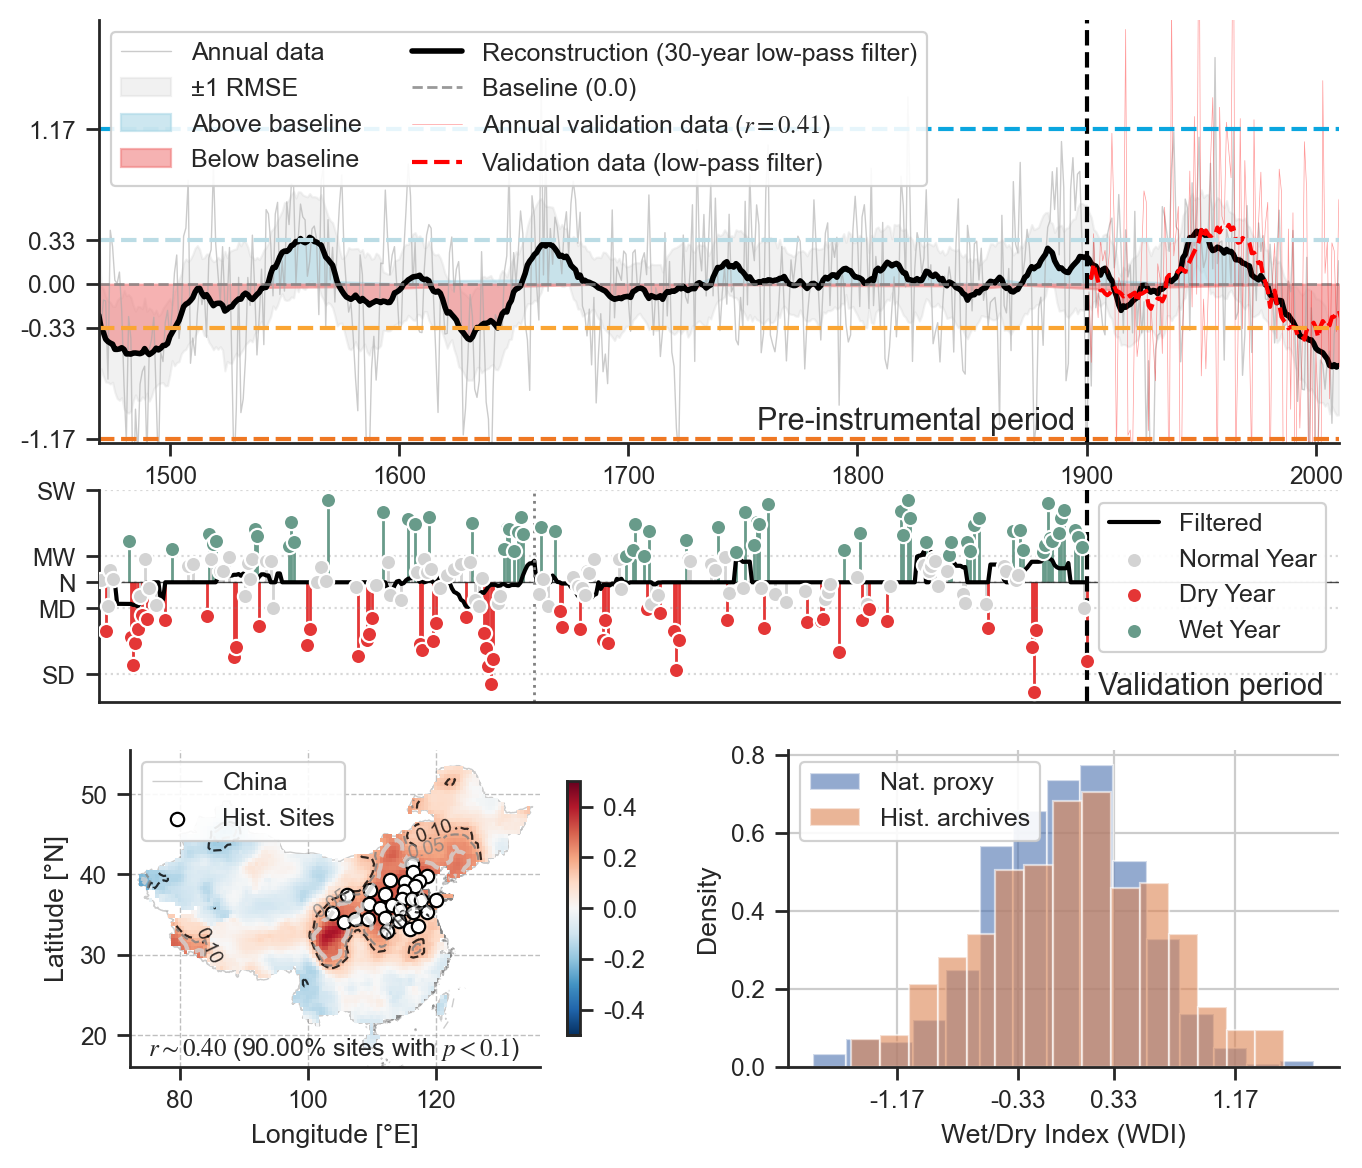

In [90]:
from shifting_baseline.utils.plot import plot_std_times
from shifting_baseline.constants import TICK_LABELS, STAGE2
from shifting_baseline.data import HistoricalRecords

fig = plt.figure(figsize=(8, 6.8), constrained_layout=False)
gs = fig.add_gridspec(
    3,
    2,
    hspace=0.15,
    wspace=0.25,
    width_ratios=[1, 1],
    height_ratios=[2, 1, 1.5],
)

# ================================================
# 自然数据
ax1 = fig.add_subplot(gs[0, :])

# 绘制时间序列
ax1 = plot_time_series_with_lowpass(
    data=tree_ring_z,
    filtered_data=mean_pass,
    baseline=0,
    rmse_data=tree_ring_std,
    ylabel="JAS Precipitation Anormaly",
    ax=ax1,
)
prec_z.plot(
    ax=ax1,
    color="red",
    lw=0.25,
    alpha=0.4,
    label=f"Annual validation data ($r={validation_corr:.2f}$)",
)
prec_z_pass.plot(
    ax=ax1,
    color="red",
    lw=1.5,
    ls="--",
    label="Validation data (low-pass filter)",
)
ax1.axvline(END, color="black", lw=1.5, ls="--")
ax1.text(
    END - 5, -1.15, "Pre-instrumental period", ha="right", va="bottom", fontsize=11
)

for th, color in zip(THRESHOLDS, COLORS):
    ax1.axhline(th, color=color, lw=1.5, ls="--")
# 设置图例
ax1.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=2)
ax1.set_xlim(STAGE1, FINAL)
ax1.set_yticks(STD_THRESHOLDS)
ax1.set_ylim(-1.2, 2)
ax1.set_title("")

# ================================================
# 历史数据
# 绘制历史数据，看看哪些年份有记录
ax2 = fig.add_subplot(gs[1, :])

history = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
    to_std="sampling",
)

data = history.aggregate(to_int=False).loc[STAGE1:END]
low_pass_filter(data=data).fillna(0).plot(
    ax=ax2, color="black", lw=1.5, label="Filtered"
)
ax2 = plot_std_times(data, ax=ax2, zorder=-1)
ax2.set_yticks(STD_THRESHOLDS)
ax2.set_xlim(STAGE1, FINAL)
ax2.set_yticklabels(TICK_LABELS)
ax2.axvline(END, color="black", lw=1.5, ls="--")
ax2.axvline(STAGE2, color="gray", lw=1, ls=":")
ax2.set_ylabel("")
ax2.legend(loc="upper right", fontsize=9, framealpha=0.9, ncol=1)
ax2.text(END + 5, -1.5, "Validation period", ha="left", va="bottom", fontsize=11)

# ================================================
# 空间分布
ax3 = fig.add_subplot(gs[2, 0])
ax3 = plot_corr_map(
    corr[0],
    corr[1],
    threshold=0.1,
    mask=False,
    base_maps=cfg.ds.base_maps,
    crs=summer_precip.rio.crs,
    ax=ax3,
)
region_gdf.plot(ax=ax3, color="white", edgecolor="black", label="Hist. Sites")
ax3.set_xlabel("Longitude [°E]")
ax3.set_ylabel("Latitude [°N]")
ax3.text(
    75,
    20,
    f'$r\sim{hist_sites_corr[mask]["r"].max():.2f}$ ({mask.sum()/len(hist_sites_corr):.2%} sites with $p<0.1$)',
    ha="left",
    va="top",
    fontsize=9,
)
ax3.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=1)

## ================================================
BINS = 15
ax4 = fig.add_subplot(gs[2, 1])
tree_ring_z.hist(density=True, alpha=0.6, bins=BINS, ax=ax4, label="Nat. proxy")
agg_hist.hist(density=True, alpha=0.6, bins=BINS, ax=ax4, label="Hist. archives")
ax4.set_ylabel("Density")
ax4.set_xlabel("Wet/Dry Index (WDI)")
ax4.set_xticks(THRESHOLDS)
ax4.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=1)

# ================================================
# 设置整体作图的样式
for ax in fig.axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
ax2.get_xaxis().set_visible(False)
plt.show();